In [1]:
import os
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
import imageio
from joblib import Parallel, delayed

In [3]:
meta = "datasets/ESC-50/meta/esc50.csv"
metaData = np.genfromtxt(meta,skip_header = True, delimiter=",", dtype='unicode')
targets = metaData[:,2].astype(int)
u, indices = np.unique(targets, return_index=True)

class_names = metaData[:,3][indices]

allAudioFiles = []
allAudioLabels = []
for file in metaData[:,0]:
    label = int((file.split('-')[-1]).split('.')[0])
    allAudioLabels.append(label)
    allAudioFiles.append(file)

In [4]:
# define directories
n_fft = 1024
hop_length = 512
n_mels = 64
srate=22050
fmin = 20
fmax = srate/2
classes = len(class_names)
base_dir = "./datasets"
esc_dir = os.path.join(base_dir, "ESC-50")
audio_dir = os.path.join(esc_dir, "audio/")

In [5]:
import random

def extractFeature(file):
    try:
        y, sr = librosa.load(audio_dir+file,sr=srate)
    except:
        raise IOError('Give me an audio  file which I can read!!')

    if len(y.shape) > 1:
        print ('Mono Conversion', )
        y = librosa.to_mono(y)

    if sr != srate:
        print ('Resampling to {}'.format(srate),)
        y = librosa.resample(y,sr,srate)
    y = y - np.mean(y)
    y = librosa.util.normalize(y)

    stft = librosa.stft(y,n_fft=n_fft, hop_length=hop_length)
    D = np.abs(stft)
    mel = librosa.feature.melspectrogram(S=D**2,sr=srate,n_mels=n_mels,fmin = fmin,fmax = fmax)
    melspectrogram = librosa.power_to_db(mel)

    return melspectrogram

In [6]:
file = allAudioFiles[300]
import IPython
noiseFile = metaData[:,0]
IPython.display.Audio(audio_dir+file)


Text(0.5, 1.0, 'Baby Cry')

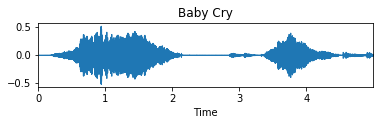

In [7]:
import matplotlib.pyplot as plt
y, sr = librosa.load(audio_dir+file, duration=5)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Baby Cry')

(64, 216)


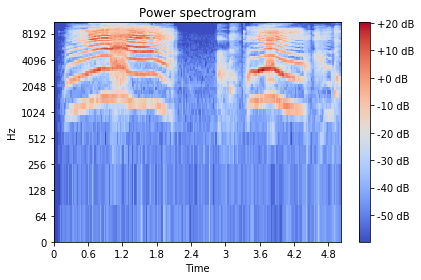

In [8]:

feat = extractFeature(file)
print(feat.shape)
import matplotlib.pyplot as plt

librosa.display.specshow(feat,y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [9]:
features = np.zeros((2000,feat.shape[0],feat.shape[1]))
labels = np.empty(0)
for i in range(len(allAudioFiles)):
    file = allAudioFiles[i]
    label = int((file.split('-')[-1]).split('.')[0])
    fold = (file.split('-')[0])
    feat = extractFeature(file)
    features[i] = feat
    labels = np.append(labels, (label,fold))

In [10]:
np.save("feat.npy",features)
np.save("labels.npy",labels)

In [13]:
num_fold = 1

X_train = np.zeros((4*len(allAudioFiles)//5,n_mels,224,1))
y_train = np.zeros(4*len(allAudioFiles)//5)

X_test = np.zeros((len(allAudioFiles)//5,n_mels,224,1))
y_test = np.zeros(len(allAudioFiles)//5)
test = 0
train = 0
for i in range(len(allAudioFiles)):
    
    file = allAudioFiles[i]
    label = allAudioLabels[i]
  
    fold = int(file.split('-')[0])
    
    if fold == num_fold:
        feat = extractFeature(file)
        img = ((feat + 80)/(120)).astype('float32')
        X_test[test,:,:216,0] = img
        y_test[test] = label
        test = test +1
    else:
        feat = extractFeature(file)
        img = ((feat + 80)/(120)).astype('float32')
        X_train[train,:,:216,0] = img
        y_train[train] = label
        train = train + 1

In [14]:
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)

np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)